In [1]:
# We want to build a model of California housing prices using
# California census data. This data has metrics such as the
# population, median income, median housing price, and so on for each
# block group in California. Block groups are the smallest
# geographical unit for which the US Census Bureau publishes sample
# data (a block group typically has a population of 600 to 3,000
# people). We will just call them "districts" for short.

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [5]:
#housing.head()


In [6]:
#housing.info()

In [7]:
#housing.describe()

In [8]:
# next line only work in Jupyter
%matplotlib inline
import matplotlib.pyplot as plt
#housing.hist(bins=50,figsize=(20,15))
#plt.show()


In [9]:
#housing["ocean_proximity"].value_counts()

In [10]:
#housing.describe()

In [11]:
# next line only work in Jupyter
# %matplotlib inline
# import matplotlib.pyplot as plt
#housing.hist(bins=50, figsize=(20,15))
#plt.show()

In [12]:
# Next we set aside a random test set
# To ensure that the test set is the same each time we run,
# we fix np.random's seed

import numpy as np

np.random.seed(42)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
#print(len(train_set), "train + ", len(test_set), "test")
# But this breaks next time we fetch an updated datasets

In [13]:
# Better method
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

# We use row index as our ID
# This is fine as long as we never delete data, and only add by appending

# First we add an 'index' column
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [14]:
# Oooor we could use Scikit-Learn's own tool for this exact task
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

In [15]:
# Just for fun, let's introduce income categories and stratify along those
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [16]:
# As a check, let's see what portions of the dataset fall into 
# each income category
# housing["income_cat"].value_counts() / len(housing)

# Now that we've checked, let's get rid of the extraneous income_cat attribute
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

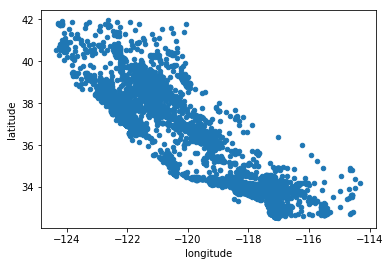

In [17]:
# Now time to visualize further
# Let's set aside the test side and only look at the training set
# We make a copy so we can play without harming the training set
housing = strat_train_set.copy()
# We can visualize the data geographically
housing.plot(kind="scatter", x="longitude", y="latitude")

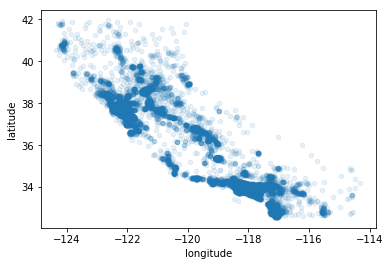

In [18]:
# Let's make it easier to visualize regions of high density
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

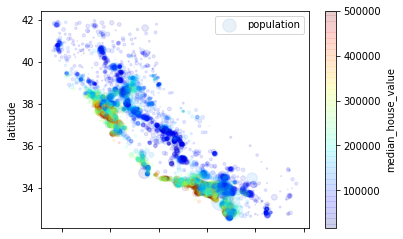

In [19]:
# We can make a more information-dense plot
# We use each dot's size (option s) to rep population
# and color (option c) to rep price
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,
            s = housing["population"]/100, label="population",
            c = "median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [ ]:
# Compute pairwise standard correlation coefficients
corr_matrix = housing.corr()

# Check correlations with median house value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [ ]:
# We can also visualize using Panda's scatter matrix,
# which plots every numerical attribute against every other
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
             "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08702128d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0870033b70>]], dtype=object)

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])

In [ ]:
housing.describe()